source: https://colab.research.google.com/drive/1zaDnAJGUokS0knqWttuTgrRJMb6zxukI

used on data from: https://github.com/Roagen7/vessel_tree_generator

weights: https://drive.google.com/uc?id=19ayDE-otx2kTcGzEhz_pv9MjnJkpX638

In [1]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
import cv2

2024-05-08 11:51:55.021684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 11:51:55.021725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 11:51:55.022645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 11:51:55.028641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 11:51:55.834726: W tensorflow/compiler/tf2

  0%|                                                                                                                                                                | 0/40 [00:00<?, ?it/s]2024-05-08 11:51:57.168545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 11:51:57.202558: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████████████████████████████████████████████████████████████████████████

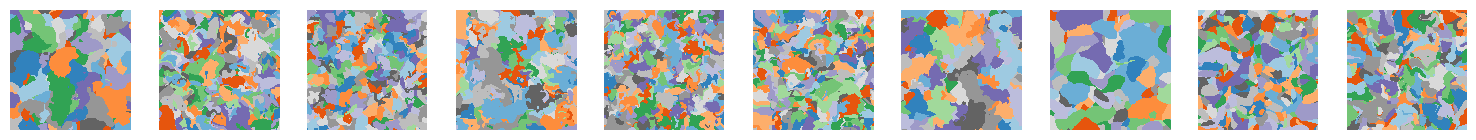

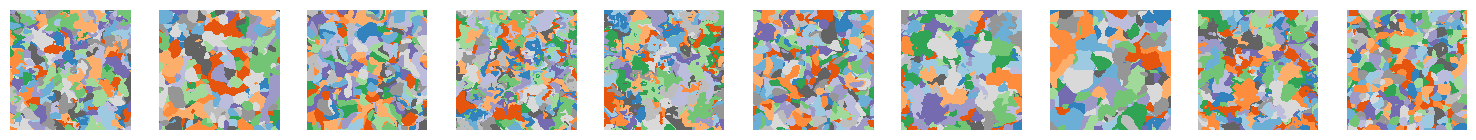

In [2]:
in_shape = (512,) * 2
num_dim = len(in_shape)
num_label = 16
num_maps = 40

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab))

num_row = 2
per_row = 10
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps[i:i + per_row], cmaps=['tab20c'])

In [3]:
# Training-image generation. For accurate registration, the landscape of warps
# and image contrasts will need to include the target distribution.
prop = dict(
    in_shape=in_shape,
    labels_in=range(num_label),
    warp_max=4,
    warp_blur_min=(8, 8),
    warp_blur_max=(64, 64),
)
model_gen_1 = ne.models.labels_to_image_new(**prop, id=1)
model_gen_2 = ne.models.labels_to_image_new(**prop, id=2)


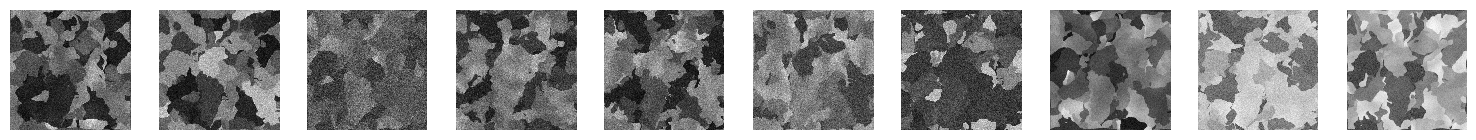

In [4]:
# Test repeatedly on the same input.
num_gen = 10
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [model_gen_1.predict(input, verbose=0)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

# Registration model.
model_def = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256] * 4, [256] * 8),
    reg_field='warp',
)


# Combined model: synthesis and registration.
ima_1, map_1 = model_gen_1.outputs
ima_2, map_2 = model_gen_2.outputs

_, warp = model_def((ima_1, ima_2))
moved = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = (*model_gen_1.inputs, *model_gen_2.inputs)
out = (map_2, moved)
model = tf.keras.Model(inputs, out)

# Contrast invariance: MSE loss on probability maps.
model.add_loss(vxm.losses.MSE().loss(*out) + tf.repeat(0., tf.shape(moved)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=0.05).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [10]:
model.load_weights('weights1.h5')

In [13]:
# Resize and normalize test images.
def conform(x, in_shape=in_shape):
    x = np.float32(x)
    x = np.squeeze(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return x[None, ..., None]


def register(moving, fixed):
    # Conform and register.
    moving = conform(moving)
    fixed = conform(fixed)
    moved, warp = model_def.predict((moving, fixed), verbose=0)

    # Visualize.
    slices = (moving, fixed, moved, warp[..., 0])
    titles = ('Moving', 'Fixed', 'Moved', 'Warp (x-axis)')
    ne.plot.slices(slices, titles, do_colorbars=True)

def open_image(path):
    pred = cv2.imread(path, 1)
    img_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

    return img_gray

    
    

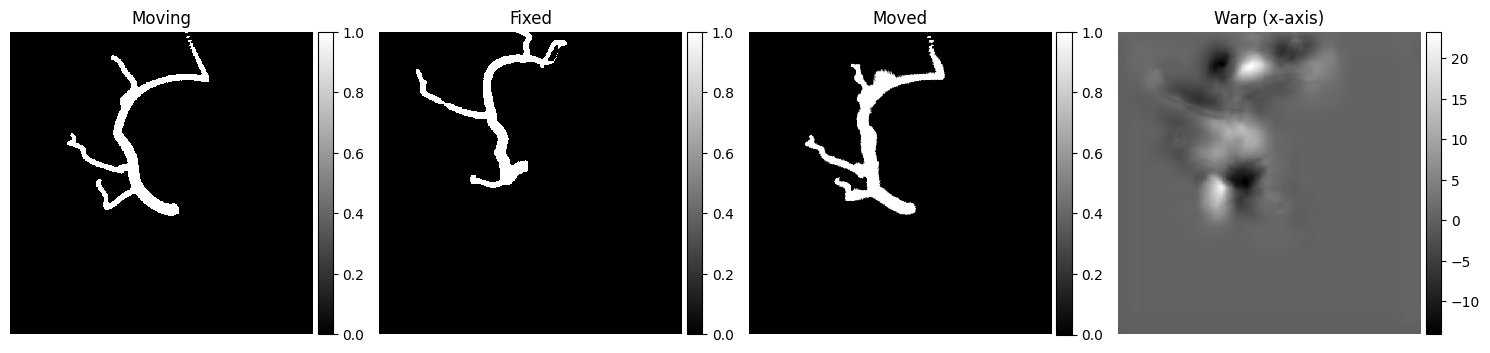

In [14]:
#images, digits = tf.keras.datasets.mnist.load_data()[-1]
#ind = np.flatnonzero(digits == 4)
path1="vessel_image0001b.png"
path2="tortuous_image0004b.png"

moving = open_image(path1)
fixed = open_image(path2)
register(moving=moving, fixed=fixed)

